## Load data

In [89]:
import h5py
import numpy as np

def load_dataset():
    train_dataset = h5py.File('data/train_signs.h5', 'r')
    train_set_x_orig = np.array(train_dataset['train_set_x'][:]) # your train set features
    train_set_y_orig = np.array(train_dataset['train_set_y'][:]) # your train set labels

    test_dataset = h5py.File('data/test_signs.h5', 'r')
    test_set_x_orig = np.array(test_dataset['test_set_x'][:]) # your test set features
    test_set_y_orig = np.array(test_dataset['test_set_y'][:]) # your test set labels

    classes = np.array(test_dataset['list_classes'][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

X_train, y_train, X_val, y_val, classes = load_dataset()

Visualize a sample data

Text(0.5,1,'Label 5')

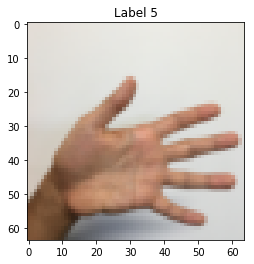

In [90]:
import matplotlib.pyplot as plt
%matplotlib inline

index = 0
plt.imshow(X_train[index])
plt.title('Label {}'.format(np.squeeze(y_train[:, index])))

Examine shapes of data

In [91]:
print("Train data:", X_train.shape)
print("Train labels:", y_train.shape)

print("Validation data:", X_val.shape)
print("Validation labels:", y_val.shape)

Train data: (1080, 64, 64, 3)
Train labels: (1, 1080)
Validation data: (120, 64, 64, 3)
Validation labels: (1, 120)


## Preprocess data

We can see that data is composed of [m, H, W, C], which:
+ m: Number of data
+ H, W: Picture's height & width
+ C: Number of channels
    
For Pytorch, we need [m, C, H, W]

In [92]:
X_train = X_train.reshape(-1, 3, 64, 64)
X_val = X_val.reshape(-1, 3, 64, 64)

Normalization: Devide by 255.

In [93]:
X_train = X_train / 255.
X_val = X_val / 255.

## Make dataset/dataloader

Convert data to Pytorch's tensors

In [135]:
import torch

X_train_tensor = torch.from_numpy(X_train.astype('float32'))
y_train_tensor = torch.from_numpy(np.squeeze(y_train).astype('int'))

X_val_tensor = torch.from_numpy(X_val.astype('float32'))
y_val_tensor = torch.from_numpy(np.squeeze(y_val).astype('int'))

Make dataset from tensors

In [136]:
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

Test dataset maker

In [137]:
print("Length of dataset:", len(train_dataset))

X_sample, y_sample = train_dataset[0]
print("Sample X:", X_sample)
print("Sample y:", y_sample)

Length of dataset: 1080
Sample X: 
(0 ,.,.) = 
  0.8902  0.8627  0.8392  ...   0.9020  0.8824  0.9137
  0.9059  0.8824  0.9098  ...   0.8980  0.9216  0.9176
  0.8941  0.9216  0.9176  ...   0.9020  0.8980  0.8667
           ...             ⋱             ...          
  0.8824  0.8706  0.8784  ...   0.8824  0.8902  0.8980
  0.8784  0.8902  0.8941  ...   0.8863  0.8863  0.8667
  0.8627  0.8431  0.8157  ...   0.8784  0.8667  0.8784

(1 ,.,.) = 
  0.8824  0.8706  0.8784  ...   0.8784  0.8863  0.8902
  0.8784  0.8863  0.8902  ...   0.8824  0.8824  0.8667
  0.8627  0.8471  0.8196  ...   0.8745  0.8588  0.8745
           ...             ⋱             ...          
  0.7412  0.8196  0.8196  ...   0.8588  0.8627  0.8510
  0.8196  0.7765  0.7333  ...   0.4000  0.3059  0.5529
  0.4078  0.3176  0.5647  ...   0.6824  0.8471  0.8549

(2 ,.,.) = 
  0.8471  0.8471  0.8549  ...   0.8588  0.8588  0.8510
  0.8118  0.7686  0.7255  ...   0.4000  0.3059  0.5725
  0.4196  0.3176  0.5961  ...   0.5020  0.7961 

Now make a data loader

In [138]:
from torch.utils.data import DataLoader

BATCH_SIZE = 128

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False)

## Build model

A basic CNN

In [216]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(32*13*13, 1024),
            nn.ReLU()
        )
        self.fc2 = nn.Linear(1024, len(classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) # flatten [m, C, H, W] -> [m, C*H*W]
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [217]:
model = CNN()
model = model.cuda() # use GPU
print(model)

CNN (
  (layer1): Sequential (
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU ()
    (3): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (layer2): Sequential (
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU ()
    (3): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (fc1): Sequential (
    (0): Linear (5408 -> 1024)
    (1): ReLU ()
  )
  (fc2): Linear (1024 -> 6)
)


In [218]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Train

In [219]:
from torch.autograd import Variable

def fit(epochs):
    history = {
        'loss': [],
        'val_acc': []
    }
    
    def train(epoch):
        model.train()

        ITERATIONS = len(train_dataset) // BATCH_SIZE + 1
        for i, (data, target) in enumerate(train_loader):
            data, target = Variable(data), Variable(target)
            data, target = data.cuda(), target.cuda() # use GPU

            ## forward 
            output = model(data)

            ## compute loss
            loss = criterion(output, target)

            ## bacwward and update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ## Regularly check
            if (i+1) % 3 == 0:
                print("({}) [{}/{}] loss: {:.4f}".format(epoch+1, i+1, ITERATIONS,
                                                         loss.data[0]))

        ## save training loss
        history['loss'].append(loss.data[0])


    def validate():
        model.eval()

        total = len(val_dataset)
        correct = 0
        for data, target in val_loader:
            data, target = Variable(data, volatile=True), Variable(target)
            data, target = data.cuda(), target.cuda() # use GPU

            # forward
            output = model(data)

            # get index of the max
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum() # check equality, then sum up

        val_acc = correct/total
        print("val_acc: {:.2f}".format(correct/total))
        
        # Save validation accuracy
        history['val_acc'].append(val_acc)        

    ## Start training, validate accuracy each epoch
    for epoch in range(0, epochs):
        train(epoch)
        validate()
    
    return history

In [220]:
EPOCHS = 30
history = fit(EPOCHS)

(1) [3/9] loss: 3.0142
(1) [6/9] loss: 3.4762
(1) [9/9] loss: 2.1518
val_acc: 0.17
(2) [3/9] loss: 1.5867
(2) [6/9] loss: 1.5706
(2) [9/9] loss: 1.3941
val_acc: 0.17
(3) [3/9] loss: 1.1215
(3) [6/9] loss: 0.9443
(3) [9/9] loss: 0.9816
val_acc: 0.19
(4) [3/9] loss: 0.9317
(4) [6/9] loss: 0.8287
(4) [9/9] loss: 0.8174
val_acc: 0.32
(5) [3/9] loss: 0.8448
(5) [6/9] loss: 0.8096
(5) [9/9] loss: 0.7164
val_acc: 0.45
(6) [3/9] loss: 0.5762
(6) [6/9] loss: 0.6605
(6) [9/9] loss: 0.4997
val_acc: 0.26
(7) [3/9] loss: 0.6047
(7) [6/9] loss: 0.5449
(7) [9/9] loss: 0.5612
val_acc: 0.24
(8) [3/9] loss: 0.3949
(8) [6/9] loss: 0.4189
(8) [9/9] loss: 0.3131
val_acc: 0.22
(9) [3/9] loss: 0.2880
(9) [6/9] loss: 0.3083
(9) [9/9] loss: 0.1573
val_acc: 0.23
(10) [3/9] loss: 0.1894
(10) [6/9] loss: 0.2947
(10) [9/9] loss: 0.2301
val_acc: 0.64
(11) [3/9] loss: 0.2017
(11) [6/9] loss: 0.1885
(11) [9/9] loss: 0.2395
val_acc: 0.65
(12) [3/9] loss: 0.1335
(12) [6/9] loss: 0.1849
(12) [9/9] loss: 0.1417
val_acc: 

Visualize training process

Text(0.5,1,'Training loss')

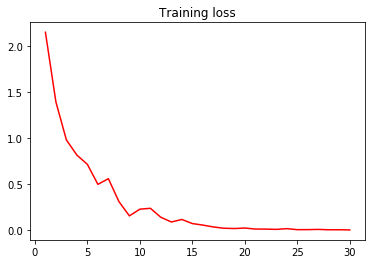

In [221]:
epochs = range(1, EPOCHS+1)

plt.plot(epochs, history['loss'], 'r')
plt.title('Training loss')

Text(0.5,1,'Validation accuracy')

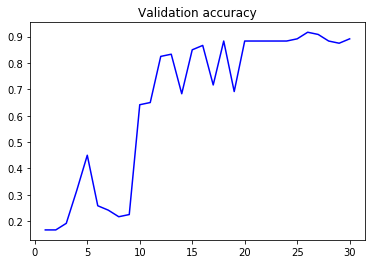

In [222]:
plt.plot(epochs, history['val_acc'], 'b')
plt.title('Validation accuracy')

## Test

In [258]:
def predict(X):
    """Arguments
        X: numpy image, shape (H, W, C)
    """
    # reshape
    shape = X.shape
    X = X.reshape((1, shape[2], shape[0], shape[1]))
    # normalize
    X = X / 255.
    
    X = torch.from_numpy(X.astype('float32'))
    X = Variable(X, volatile=True)
    
    # forward
    output = model.cpu()(X)

    # get index of the max
    _, index = output.data.max(1, keepdim=True)
    return classes[index[0][0]] # index is a LongTensor -> need to get int data

Sample predict from validation data

Text(0.5,1,'Label: 3, Predict: 3')

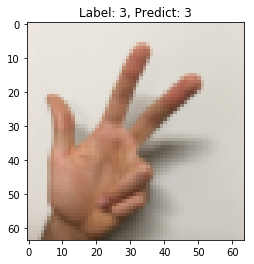

In [265]:
import random

_, _, X_val, y_val, classes = load_dataset()
index = random.randint(0, len(X_val))

pred = predict(X_val[index])

plt.imshow(X_val[index])
plt.title('Label: {}, Predict: {}'.format(np.squeeze(y_val[:,index]), pred))